# Library Download & Installation (Task 1)


In [1]:
# install Pint if necessary

try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

# Task 2

In [3]:
# import functions from modsim

from modsim import *

mass=float(input('Enter Mass: '))                                                #taking inputs as instructed
diameter=float(input("Enter Diameter: "))
density=float(input("Enter Density: "))

init = State(y=58, v=0)                                                         #height of the spaceshup and initial velocity

system = System(init=init, 
                g=9.8*0.38,                                                     #the average gravitational acceleration is 38% of that of Earth
                t_end=10)
def slope_func(t, state, system):
    y, v = state

    dydt = v
    dvdt = -system.g
    
    return dydt, dvdt
def event_func(t, state, system):
    y, v = state
    return y
results, details = run_solve_ivp(system, slope_func,events=event_func)
print(details.message)
dydt, dvdt = slope_func(0, system.init, system)
print(dydt, dvdt)
results.head()

Enter Mass: 1
Enter Diameter: 0.2
Enter Density: 1.2
A termination event occurred.
0 -3.724


,y,v
0.000000,58.0000,0.000000
0.055812,57.9942,-0.207842
0.111623,57.9768,-0.415684
0.167435,57.9478,-0.623527
0.223246,57.9072,-0.831369


Flight Time: 5.5811559578633485


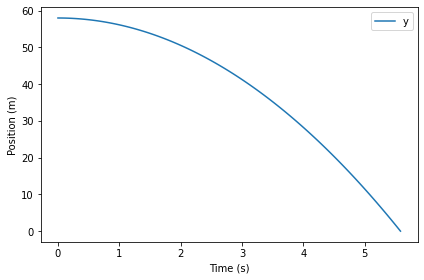

In [4]:
def plot_position_0(results):
  t_end = results.index[-1]
  print('Flight Time:',t_end)
  y, v = results.iloc[-1]
  results.y.plot()
        
  decorate(xlabel='Time (s)',
  ylabel='Position (m)')
    
plot_position_0(results)

# Task 3

In [5]:
density=float(input("Enter Density: "))                                           
enemy_height=3

params = Params(
    mass = 1,                   # kg                                            #mass does not matter in free falls that's why 1 kg (unless it's significantly massive)
    diameter = 0.2,             # m                                             #pennies are all 20 cm in diameter (fixed)
    rho = density,              # kg/m**3                                       #no instruction was given for this, therfore user input
    g = 9.8*0.38,               # m/s**2                                        #the average gravitational acceleration is 38% of that of Earth
    v_init = 0,                 # m / s
    v_term = 40,                # m / s                                         #increased terminal velocity (40 m/s)
    height = 58-enemy_height,   # m                                             #fall distance = height of spaceship - height of enemy (3 m)
    t_end = 30,                 # s
)

from numpy import pi


#this will compute the initial state
def make_system(params):
    init = State(y=params.height, v=params.v_init)

    area = pi * (params.diameter/2)**2

    C_d = (2 * params.mass * params.g / 
           (params.rho * area * params.v_term**2))                              #drag coefficient

    return System(init=init,
                  area=area,
                  C_d=C_d,
                  mass=params.mass,
                  rho=params.rho,
                  g=params.g,
                  t_end=params.t_end)
    
system = make_system(params)

print('Drag Coefficient:',system.C_d)

#slope function that includes drag
def slope_func(t, state, system):
    y, v = state
    rho, C_d, area = system.rho, system.C_d, system.area
    mass, g = system.mass, system.g
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

slope_func(0, system.init, system)

#To stop the simulation when the penny hits
def event_func(t, state, system):
    y, v = state
    return y

results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
print(details.message)

results.tail()

t_sidewalk = results.index[-1]
print('Flight Time:',t_sidewalk) 


Enter Density: 1.2
Drag Coefficient: 0.12347771001546214
A termination event occurred.
Flight Time: 5.55217658160661


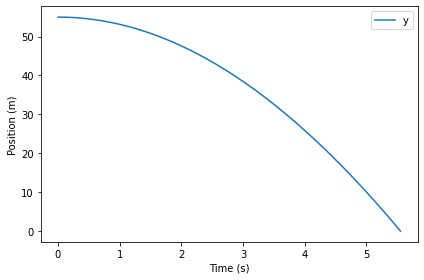

In [6]:
def plot_position(results):
    results.y.plot()
        
    decorate(xlabel='Time (s)',
         ylabel='Position (m)')
    
plot_position(results)




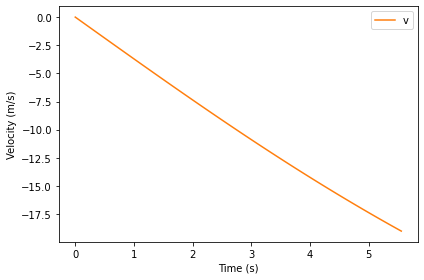

In [7]:
def plot_velocity(results):

    results.v.plot(color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

Final Velocity Before Hitting:  -19.00831473839419


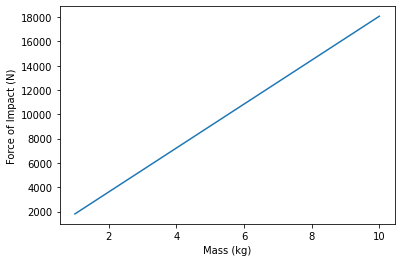

In [8]:
various_mass = np.linspace(1, 10, 40)                                           #as it's a huge penny with the diameter 20cm, the value of mass will be large

v_hit=results.iloc[-1][1]                                                       #getting the final velocity before hitting
print('Final Velocity Before Hitting: ',v_hit)

def force_list(mass,v_hit):

  E_k= (mass*(v_hit)**2)/2                                                      #kinetic energy, E_k=((m*v)**2)/2
  F_i= E_k/0.1                                                                  #Collision duration = 0.1

  return F_i

forces_list = force_list(various_mass,v_hit)

def plot_force_of_impact(x,y):
  plt.plot(x,y)
  plt.xlabel("Mass (kg)")
  plt.ylabel("Force of Impact (N)")
  plt.show()
  

plot_force_of_impact(various_mass,forces_list)

# Task 4

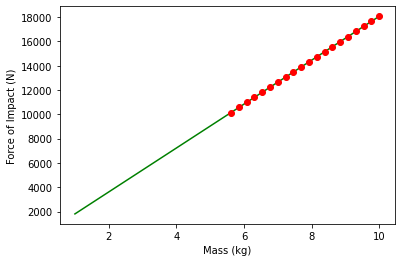

In [9]:
condition = (forces_list > 10000)                                               #will require 10,000 Newton force to crack enemy's skull, creating a condition to extract only critical forces
extracted_forces_list = np.extract(condition, forces_list)                      #extracting critical forces

critical_points_length = len(various_mass) - len(extracted_forces_list)         #Getting the length of critical forces list to slice the list of various mass, according to critical forces 
critical_mass = various_mass[critical_points_length:]                           #Slicing the list

def plot_force_of_impact(x,y,x_hit,y_hit):
  plt.plot(x,y,'g-',label='All')                                                #all points
  plt.plot(x_hit,y_hit,'ro',label='Critical Mass')                              #critical points are plotted with green dots
  plt.xlabel("Mass (kg)")
  plt.ylabel("Force of Impact (N)")
  plt.show()


plot_force_of_impact(various_mass,forces_list,critical_mass,extracted_forces_list)